## Notes:
1. Decision tree regressor and Random Forest - final comparison
2. SVM super bad with a baseline - why? (not much important but check)
3. Decision tree regressor - worsens with tuning
4. Linear does not change with tuning
5. Study the paramters that were choosen and why were they choosen. 


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import gaussian_kde
from numpy.polynomial.polynomial import polyfit


In [2]:
df = pd.read_csv("coursework_other.csv", encoding= "unicode_escape")
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
# convert Date to datetime object
df["Date"] = pd.to_datetime(df["Date"])


In [4]:
df.set_index("Date", inplace=True)
df.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
Date,,,,,,,,,,,,,
2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [5]:
# rename the columns for ease of use

df.rename({"Rented Bike Count": "rented_bike_count", 
           "Hour": "hour",
           "Temperature(°C)": "temp_celcius",
           "Humidity(%)": "humidity_percent",
           "Wind speed (m/s)": "wind_speed_ms",
           "Visibility (10m)": "visibility_10m",
           "Dew point temperature(°C)": "dew_point_temp_celcius",
           "Solar Radiation (MJ/m2)": "solar_radiations",
           "Rainfall(mm)": "rainfall_mm",
           "Snowfall (cm)": "snowfall_cm",
           "Seasons": "seaons",
           "Holiday": "holiday",
           "Functioning Day": "functioning_day"}, axis=1, inplace=True)
df.head()

,rented_bike_count,hour,temp_celcius,humidity_percent,wind_speed_ms,visibility_10m,dew_point_temp_celcius,solar_radiations,rainfall_mm,snowfall_cm,seaons,holiday,functioning_day
Date,,,,,,,,,,,,,
2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [6]:
print(df['seaons'].unique())
print(df['holiday'].unique())

['Winter' 'Spring' 'Summer' 'Autumn']
['No Holiday' 'Holiday']


In [7]:
def season_to_numeric(season):
    if season == "Winter":
        return 0
    elif season == "Spring":
        return 1
    elif season == "Summer":
        return 2
    elif season == "Autumn":
        return 3
    
    
def day_to_numeric(day):
    if day == "Yes":
        return 1
    elif day == "No":
        return 0
    
def holiday_to_numeric(holiday):
    if holiday == "Holiday":
        return 1
    elif holiday == "No Holiday":
        return 0

In [8]:
df["seasons_num"] = df["seaons"].apply(lambda x: season_to_numeric(x))
df["functioning_day_num"] = df["functioning_day"].apply(lambda x: day_to_numeric(x))
df["holiday_num"] = df["holiday"].apply(lambda x: holiday_to_numeric(x))

df.head()

,rented_bike_count,hour,temp_celcius,humidity_percent,wind_speed_ms,visibility_10m,dew_point_temp_celcius,solar_radiations,rainfall_mm,snowfall_cm,seaons,holiday,functioning_day,seasons_num,functioning_day_num,holiday_num
Date,,,,,,,,,,,,,,,,
2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0,1,0
2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0,1,0
2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,0,1,0
2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0,1,0
2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0,1,0


In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression


X = df[df.columns[~df.columns.isin(["rented_bike_count", "seaons", "holiday", "functioning_day"])]]
y = df["rented_bike_count"]
print(X.shape)

X_new = SelectKBest(f_regression).fit_transform(X, y)
print(X_new.shape)

(8760, 12)
(8760, 10)


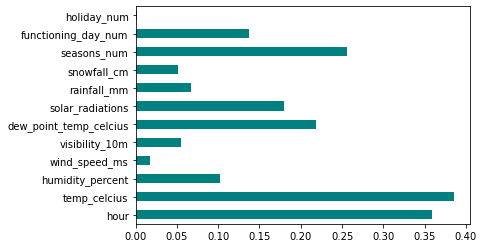

In [10]:
important_features = mutual_info_regression(X,y)
important_features_series = pd.Series(important_features, X.columns[0:len(X.columns)])
important_features_series.plot(kind='barh', color='teal')
plt.show()

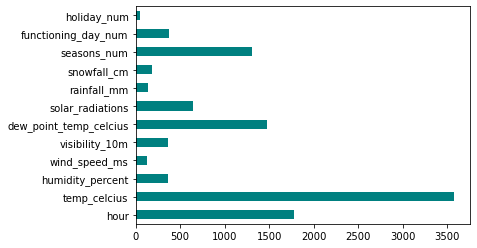

In [11]:
f_test, _ = f_regression(X, y)
f_test_important_features_series = pd.Series(f_test, X.columns[0:len(X.columns)])
f_test_important_features_series.plot(kind='barh', color='teal')
plt.show()

In [12]:
df.index +=  pd.to_timedelta(df.hour, unit='h')
df.head()

,rented_bike_count,hour,temp_celcius,humidity_percent,wind_speed_ms,visibility_10m,dew_point_temp_celcius,solar_radiations,rainfall_mm,snowfall_cm,seaons,holiday,functioning_day,seasons_num,functioning_day_num,holiday_num
2017-01-12 00:00:00,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0,1,0
2017-01-12 01:00:00,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0,1,0
2017-01-12 02:00:00,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,0,1,0
2017-01-12 03:00:00,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0,1,0
2017-01-12 04:00:00,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,0,1,0


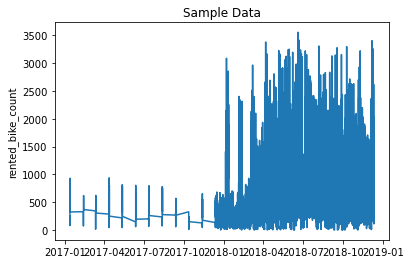

In [13]:
fig, ax = plt.subplots()
sns.lineplot(x=df.index, y=df.rented_bike_count, data=df, ax=ax)
ax.set(title='Sample Data');

# Training model from the features selected based on the mutual_info_regression test - holiday_num, rainfall least important

In [14]:
X_1 = df[df.columns[~df.columns.isin(["rented_bike_count", "seaons", "holiday", "functioning_day", "holiday_num", "wind_speed_ms"])]]
y_1 = df["rented_bike_count"]

In [15]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X_1, y_1, test_size=0.3)

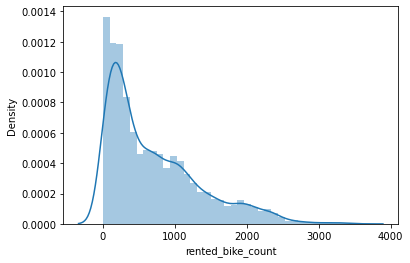

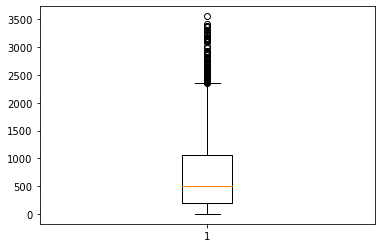

count    6132.000000
mean      705.564416
std       645.086895
min         0.000000
25%       194.000000
50%       507.000000
75%      1061.000000
max      3556.000000
Name: rented_bike_count, dtype: float64

In [16]:
sns.distplot(y1_train,hist=True)
plt.show()

plt.boxplot(y1_train)
plt.show()


display(y1_train.describe());

# Baseline Model

In [17]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [18]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score


dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X1_train, y1_train)

y1_pred = dummy_regr.predict(X1_test)


scores=cross_val_score(dummy_regr, X1_train, y1_train, cv=10, scoring='r2')
r2_scores=scores
cross_validation_score_mse=r2_scores.mean()
    
#Output of the mean square error
print("R2 by cross validation "+str(cross_validation_score_mse))
print("MAE",mean_absolute_error(y1_test,y1_pred))
print("MSE",mean_squared_error(y1_test,y1_pred))
print("RMSE",np.sqrt(mean_squared_error(y1_test,y1_pred)))
r2 = r2_score(y1_test,y1_pred)
print("R2 ",r2)

R2 by cross validation -0.0018075295223650035
MAE 521.8257157849483
MSE 415755.6713047268
RMSE 644.7911842641204
R2  -2.47517798135366e-05


# Regression Model

In [40]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X1_train, y1_train)

y1_pred = lr.predict(X1_test)


scores=cross_val_score(lr, X1_train, y1_train, cv=10, scoring='r2')
r2_scores=scores
cross_validation_score_mse=r2_scores.mean()
    
#Output of the mean square error
print("R2 by cross validation "+str(cross_validation_score_mse))
print("MAE",mean_absolute_error(y1_test,y1_pred))
print("MSE",mean_squared_error(y1_test,y1_pred))
print("RMSE",np.sqrt(mean_squared_error(y1_test,y1_pred)))
r2 = r2_score(y1_test,y1_pred)
print("R2 ",r2)

R2 by cross validation 0.5353194358483767
MAE 322.0532828462098
MSE 187062.48854283433
RMSE 432.50721212811504
R2  0.5500551607983915


In [57]:
fit_intercept = [True, False]
normalize = [True, False]
positive = [True, False]
n_jobs = [x for x in range(1,500)]

linear_grid = {'fit_intercept' : fit_intercept,
               'normalize' : normalize,
               'n_jobs' : n_jobs,
               'positive' : positive
               }

print(linear_grid)

{'fit_intercept': [True, False], 'normalize': [True, False], 'n_jobs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 2

In [58]:
lr.get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])

In [66]:
lr_random = RandomizedSearchCV(estimator = lr, param_distributions = linear_grid, n_iter = 10, cv = 3)
# Fit the random search model
lr_random.fit(X1_train, y1_train)

RandomizedSearchCV(cv=3, estimator=LinearRegression(),
                   param_distributions={'fit_intercept': [True, False],
                                        'n_jobs': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, 30, ...],
                                        'normalize': [True, False],
                                        'positive': [True, False]})

In [68]:
lr_random.best_params_

{'positive': False, 'normalize': True, 'n_jobs': 269, 'fit_intercept': True}

In [67]:
scores=cross_val_score(lr_random, X1_train, y1_train, cv=10, scoring='r2')
r2_scores=scores
cross_validation_score_mse=r2_scores.mean()
    
#Output of the mean square error
print("R2 by cross validation "+str(cross_validation_score_mse))
print("MAE",mean_absolute_error(y1_test,y1_pred))
print("MSE",mean_squared_error(y1_test,y1_pred))
print("RMSE",np.sqrt(mean_squared_error(y1_test,y1_pred)))
r2 = r2_score(y1_test,y1_pred)
print("R2 ",r2)

R2 by cross validation 0.5353194358483767
MAE 168.2660666652409
MSE 77459.88724350027
RMSE 278.3161641793381
R2  0.8136843106181026


In [20]:
from sklearn.svm import SVR

# Choose regression method and set hyperparameter
svr_rbf=SVR(C=1.0, epsilon=0.2, kernel='rbf')

# Training of the regression model
svr_rbf.fit(X1_train, y1_train)
y1_pred = svr_rbf.predict(X1_test)

print("MAE",mean_absolute_error(y1_test,y1_pred))
print("MSE",mean_squared_error(y1_test,y1_pred))
print("RMSE",np.sqrt(mean_squared_error(y1_test,y1_pred)))
r2 = r2_score(y1_test,y1_pred)
print("R2", r2)

MAE 490.57914156639663
MSE 434942.50721969246
RMSE 659.5017113091462
R2 -0.04617520058328917


In [21]:
from sklearn.ensemble import RandomForestRegressor

# define used regressor
forest=RandomForestRegressor(n_estimators=20,
                             max_depth=10,
                             criterion='mse',
                            )

# train model
forest.fit(X1_train,y1_train)
y1_pred = forest.predict(X1_test)
print("MAE",mean_absolute_error(y1_test,y1_pred))
print("MSE",mean_squared_error(y1_test,y1_pred))
print("RMSE",np.sqrt(mean_squared_error(y1_test,y1_pred)))
r2 = r2_score(y1_test,y1_pred)
print(r2)

scores=cross_val_score(forest, X1_train, y1_train, cv=10, scoring='r2')
mse_scores=scores
cross_validation_score_mse=mse_scores.mean()
print("MSE by cross validation of polynomial regression:"+str(cross_validation_score_mse))



MAE 148.7561085554961
MSE 56549.5687501155
RMSE 237.80153227032727
0.8639802837201928
MSE by cross validation of polynomial regression:0.8535229230299585


In [22]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [23]:
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X1_train, y1_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   8.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   8.3s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   4.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   8.1s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  12.0s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   4.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  18.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  13.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   4.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  18.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  23.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.9s
[CV] END bootstrap=False, max_dep

RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(criterion='mse',
                                                   max_depth=10,
                                                   n_estimators=20),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
             

In [24]:
y_pred = rf_random.predict(X1_test)
print("MAE",mean_absolute_error(y1_test,y1_pred))
print("MSE",mean_squared_error(y1_test,y1_pred))
print("RMSE",np.sqrt(mean_squared_error(y1_test,y1_pred)))
r2 = r2_score(y1_test,y1_pred)
print(r2)

scores=cross_val_score(rf_random, X1_train, y1_train, cv=10, scoring='r2')
mse_scores=scores
cross_validation_score_mse=mse_scores.mean()
print("MSE by cross validation of polynomial regression:"+str(cross_validation_score_mse))


MAE 148.7561085554961
MSE 56549.5687501155
RMSE 237.80153227032727
0.8639802837201928
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.2s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  21.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.5s
[CV] END bootstrap=False, max_depth=

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.4s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  11.9s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.1s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  20.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  32.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  32.5s
Fitting 3 folds for each of 10 candi

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  11.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.1s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  11.8s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.3s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  21.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.4s
[CV] END bootstrap=False, max_depth

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  17.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  21.3s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.8s
[CV] END bootstrap=False, max_depth=

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.1s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  20.5s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  32.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  32.7s
Fitting 3 folds for each of 10 candi

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  11.8s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.8s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  20.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  32.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  32.9s
Fitting 3 folds for each of 10 candi

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.1s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  11.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  11.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_dept

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  20.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  32.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.1s
[CV] END bootstrap=False, max_depth=

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  21.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.5s
Fitting 3 folds for each of 10 candi

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  11.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.6s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  17.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  20.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  11.1s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.5s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  11.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.7s
[CV] END bootstrap=False, max_depth=

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  17.2s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  21.5s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  32.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  32.9s
MSE by cross validation of polynomia

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.2s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, 

In [72]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=2, max_depth=10)

dtr.fit(X1_train,y1_train)
y1_pred = dtr.predict(X1_test)
print("MAE",mean_absolute_error(y1_test,y1_pred))
print("MSE",mean_squared_error(y1_test,y1_pred))
print("RMSE",np.sqrt(mean_squared_error(y1_test,y1_pred)))
r2 = r2_score(y1_test,y1_pred)
print(r2)

scores=cross_val_score(dtr, X1_train, y1_train, cv=10, scoring='r2')
mse_scores=scores
cross_validation_score_mse=mse_scores.mean()
print("MSE by cross validation of polynomial regression:"+str(cross_validation_score_mse))

MAE 168.2660666652409
MSE 77459.88724350027
RMSE 278.3161641793381
0.8136843106181026
MSE by cross validation of polynomial regression:0.8015658170366443


In [122]:
# splitter = ['best', 'random'] -> choosing random reduces the score
max_depth = [x for x in range(0,10)]
# min_samples_split = [x for x in range(0,500)] - removing these increased the accuracy
# min_samples_leaf = [x for x in range(0,500)]
max_features = [x for x in range(0,11)]
random_state = [x for x in range(0,100)]
# max_leaf_nodes = [x for x in range(0,500)]

decision_grid = {'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'random_state': random_state,
#                'max_leaf_nodes': max_leaf_nodes
                }

print(decision_grid)

{'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'max_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'random_state': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]}


In [123]:
dtr_random = RandomizedSearchCV(estimator = dtr, param_distributions = decision_grid, n_iter = 10, cv = 3)
# Fit the random search model
dtr_random.fit(X1_train, y1_train)

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeRegressor(max_depth=10,
                                                   random_state=2),
                   param_distributions={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                      9],
                                        'max_features': [0, 1, 2, 3, 4, 5, 6, 7,
                                                         8, 9, 10],
                                        'random_state': [0, 1, 2, 3, 4, 5, 6, 7,
                                                         8, 9, 10, 11, 12, 13,
                                                         14, 15, 16, 17, 18, 19,
                                                         20, 21, 22, 23, 24, 25,
                                                         26, 27, 28, 29, ...]})

In [124]:
y1_pred = dtr_random.predict(X1_test)
print("MAE",mean_absolute_error(y1_test,y1_pred))
print("MSE",mean_squared_error(y1_test,y1_pred))
print("RMSE",np.sqrt(mean_squared_error(y1_test,y1_pred)))
r2 = r2_score(y1_test,y1_pred)
print(r2)

scores=cross_val_score(dtr_random, X1_train, y1_train, cv=10, scoring='r2')
mse_scores=scores
cross_validation_score_mse=mse_scores.mean()
print("MSE by cross validation of polynomial regression:"+str(cross_validation_score_mse))

MAE 179.56952548566196
MSE 85367.58319773054
RMSE 292.1773146528158
0.7946637843100363
MSE by cross validation of polynomial regression:0.7895644167831832


# F-test feature selection

In [127]:
X_2 = df[df.columns[~df.columns.isin(["rented_bike_count", "seaons", "holiday", "functioning_day", "holiday_num", "wind_speed_ms", "snowfall_cm", "rainfall_mm"])]]
y_2 = df["rented_bike_count"]

In [128]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, y_2, test_size=0.3)

In [129]:
dummy_regr2 = DummyRegressor(strategy="mean")
dummy_regr2.fit(X2_train, y2_train)

y2_pred = dummy_regr.predict(X2_test)


scores=cross_val_score(dummy_regr2, X2_train, y2_train, cv=20, scoring='r2')
r2_scores=scores
cross_validation_score_mse=r2_scores.mean()
    
#Output of the mean square error
print("R2 by cross validation "+str(cross_validation_score_mse))
print("MAE",mean_absolute_error(y2_test,y2_pred))
print("MSE",mean_squared_error(y2_test,y2_pred))
print("RMSE",np.sqrt(mean_squared_error(y2_test,y2_pred)))
r2 = r2_score(y2_test,y2_pred)
print("R2 ",r2)

R2 by cross validation -0.0031579160368699123
MAE 539.0725386003111
MSE 448051.47854394204
RMSE 669.366475515425
R2  -0.0011528663514324133


# Regression Model Selection

In [131]:
from sklearn.linear_model import LinearRegression

lr2 = LinearRegression()
lr2.fit(X2_train, y2_train)

y2_pred = lr2.predict(X2_test)


scores=cross_val_score(lr2, X2_train, y2_train, cv=20, scoring='r2')
r2_scores=scores
cross_validation_score_mse=r2_scores.mean()
    
#Output of the mean square error
print("R2 by cross validation "+str(cross_validation_score_mse))
print("MAE",mean_absolute_error(y2_test,y2_pred))
print("MSE",mean_squared_error(y2_test,y2_pred))
print("RMSE",np.sqrt(mean_squared_error(y2_test,y2_pred)))
r2 = r2_score(y2_test,y2_pred)
print("R2 ",r2)

R2 by cross validation 0.5265192002090628
MAE 337.6883644347279
MSE 207471.49257990703
RMSE 455.4903869237056
R2  0.5364133600058794


In [132]:
lr2_random = RandomizedSearchCV(estimator = lr2, param_distributions = linear_grid, n_iter = 10, cv = 3)
# Fit the random search model
lr2_random.fit(X2_train, y2_train)

RandomizedSearchCV(cv=3, estimator=LinearRegression(),
                   param_distributions={'fit_intercept': [True, False],
                                        'n_jobs': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, 30, ...],
                                        'normalize': [True, False],
                                        'positive': [True, False]})

In [134]:
y2_pred = lr2_random.predict(X2_test)

scores=cross_val_score(lr2_random, X2_train, y2_train, cv=20, scoring='r2')
r2_scores=scores
cross_validation_score_mse=r2_scores.mean()
    
#Output of the mean square error
print("R2 by cross validation "+str(cross_validation_score_mse))
print("MAE",mean_absolute_error(y2_test,y2_pred))
print("MSE",mean_squared_error(y2_test,y2_pred))
print("RMSE",np.sqrt(mean_squared_error(y2_test,y2_pred)))
r2 = r2_score(y2_test,y2_pred)
print("R2 ",r2)

R2 by cross validation 0.5259726170912002
MAE 337.1414161415003
MSE 207318.39442514325
RMSE 455.32229730724066
R2  0.5367554516266302


In [136]:
## from sklearn.svm import SVR

# Choose regression method and set hyperparameter
svr_rbf=SVR()

# Training of the regression model
svr_rbf.fit(X2_train, y2_train)
y2_pred = svr_rbf.predict(X2_test)

print("MAE",mean_absolute_error(y2_test,y2_pred))
print("MSE",mean_squared_error(y2_test,y2_pred))
print("RMSE",np.sqrt(mean_squared_error(y2_test,y2_pred)))
r2 = r2_score(y2_test,y2_pred)
print("R2", r2)

MAE 510.34433820711155
MSE 477761.6545787761
RMSE 691.2030487337105
R2 -0.06753905035364127


In [138]:
from sklearn.ensemble import RandomForestRegressor

# define used regressor
forest2=RandomForestRegressor(n_estimators=20,
                             max_depth=20,
                             criterion='mse',
                            )

# train model
forest2.fit(X2_train,y2_train)
y2_pred = forest2.predict(X2_test)
print("MAE",mean_absolute_error(y2_test,y2_pred))
print("MSE",mean_squared_error(y2_test,y2_pred))
print("RMSE",np.sqrt(mean_squared_error(y2_test,y2_pred)))
r2 = r2_score(y2_test,y2_pred)
print(r2)

scores=cross_val_score(forest2, X2_train, y2_train, cv=20, scoring='r2')
mse_scores=scores
cross_validation_score_mse=mse_scores.mean()
print("MSE by cross validation of polynomial regression:"+str(cross_validation_score_mse))



MAE 156.82599649517633
MSE 63640.554905894
RMSE 252.27079677579408
0.8577977598304414
MSE by cross validation of polynomial regression:0.8415337587457152


In [139]:
rf2_random = RandomizedSearchCV(estimator = forest2, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf2_random.fit(X2_train, y2_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.5s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.6s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.8s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  12.1s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  18.4s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  13.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  18.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  23.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  12.3s
[CV] END bootstrap=False, max_dept

RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(criterion='mse',
                                                   max_depth=20,
                                                   n_estimators=20),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
             

In [141]:
y2_pred = rf2_random.predict(X2_test)
print("MAE",mean_absolute_error(y2_test,y2_pred))
print("MSE",mean_squared_error(y2_test,y2_pred))
print("RMSE",np.sqrt(mean_squared_error(y2_test,y2_pred)))
r2 = r2_score(y2_test,y2_pred)
print(r2)

scores=cross_val_score(rf2_random, X2_train, y2_train, cv=20, scoring='r2')
mse_scores=scores
cross_validation_score_mse=mse_scores.mean()
print("MSE by cross validation of polynomial regression:"+str(cross_validation_score_mse))


MAE 153.1624708385147
MSE 59587.15446903298
RMSE 244.10480222444002
0.8668549187957935
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.9s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.9s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  11.4s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  17.1s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.3s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  17.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  22.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  11.5s
[CV] END bootstrap=False, max_dept

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.0s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   7.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  11.3s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  17.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  22.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  11.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  34.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  11.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  35.1s
[CV] END bootstrap=False, max_depth=

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.9s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  17.2s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  21.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.5s
[CV] END bootstrap=False, max_depth=90

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.6s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.2s
[CV] END bootstrap=True, max_depth=10, m

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.7s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  22.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.7s
[CV] END bootstrap=False, max_dept

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.8s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.7s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  21.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  34.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  11.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  34.3s
[CV] END bootstrap=False, max_depth=

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.6s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.6s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, m

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.7s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.6s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.7s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  22.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.7s
[CV] END bootstrap=False, max_depth=

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.6s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  17.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  21.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.6s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.8s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  17.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  21.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.2s
[CV] END bootstrap=True, max_depth=

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.5s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  21.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  34.5s
[CV] END bootstrap=False, max_depth

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.9s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.5s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.6s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.8s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=True, max_depth=10,

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  21.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.8s
[CV] END bootstrap=False, max_dept

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.6s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  21.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  34.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.2s
[CV] END bootstrap=True, max_depth=

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.7s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  17.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  22.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  34.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  11.1s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  34.3s
Fitting 3 folds for each of 10 cand

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  11.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  21.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   6.7s


/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  21.8s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   2.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  34.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  10.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=  33.7s
[CV] END bootstrap=False, max_depth

/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/Users/samruddhimhatre/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed i

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.8s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=  12.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=   3.1s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time=  16.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time=  21.5s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=  11.0s
[CV] END bootstrap=True, max_depth

KeyboardInterrupt: 